In [7]:
# http://betatim.github.io/posts/bayesian-hyperparameter-search/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import george
import random
import seaborn as sns

from scipy import stats
from scipy.optimize import minimize
from george.kernels import ExpSquaredKernel
from scipy.stats import randint as sp_randint

sns.set_style('whitegrid')
sns.set_context("talk")

np.random.seed(9)

In [2]:
#
# Helper plot function (use global variable).
#
def basic_plot():
  fig, ax = plt.subplots()
  ax.plot(x, mu, label="GP median")
  ax.fill_between(x, mu-std, mu+std, alpha=0.5)
  ax.plot(x, score_func(x), '--', label=" True score function (unknown)")
  # explicit zorder to draw points and errorbars on top of everything
  ax.errorbar(xp, yp, yerr=yerr, fmt='ok', zorder=3, label="samples")
  ax.set_ylim(-9,6)
  ax.set_ylabel("score")
  ax.set_xlabel('hyper-parameter X')
  ax.legend(loc='best')
  return fig, ax

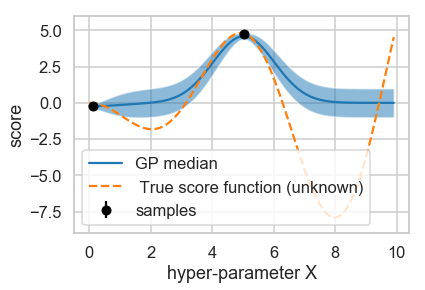

In [3]:
#
# Objective Function and Gaussian Process
#
# Below we setup a toy scoring function (-xsinx), sample two points from it,
# and fit our gaussian process model to it. This is exactly the same as what we
# do in gaussian.ipynb.
#
# - The dashed line is the true scoring function.
# - The solid line the gaussian process median value.
# - The shaded area represents the uncertainty on the median.
score_func = lambda x: -x*np.sin(x)
x = np.arange(0, 10, 0.1) # Return 100 evenly spaced values within [0, 10)

# Generate some fake, noisy data. These represent the points in hyper-parameter
# space for which we already trained our classifier and evaluated its score.
xp = 10 * np.sort(np.random.rand(2)) # Generate two points
yerr = 0.2 * np.ones_like(xp)
yp = score_func(xp) + yerr * np.random.randn(len(xp))

# Set up a Gaussian process.
kernel = ExpSquaredKernel(1)
gp = george.GP(kernel)

gp.compute(xp, yerr)
mu, cov = gp.predict(yp, x) # Predict the function
std = np.sqrt(np.diag(cov))

basic_plot()
plt.show()

In [8]:
#
# Bayesian Optimization
#
# Now we use bayesian optimization to suggest the next point to evaluatee. We do
# this via expected improvement at every value of the hyper-parameter.
def expected_improvement(points, gp, samples, bigger_better=False):
  # are we trying to maximise a score or minimise an error?
  if bigger_better:
    best_sample = samples[np.argmax(samples)]
    mu, cov = gp.predict(samples, points)
    sigma = np.sqrt(cov.diagonal())
    Z = (mu-best_sample)/sigma
    ei = ((mu-best_sample) * stats.norm.cdf(Z) + sigma*stats.norm.pdf(Z))
    # want to use this as objective function in a minimiser so multiply by -1
    return -ei
  else:
    best_sample = samples[np.argmin(samples)]
    mu, cov = gp.predict(samples, points)
    sigma = np.sqrt(cov.diagonal())
    Z = (best_sample-mu)/sigma
    ei = ((best_sample-mu) * stats.norm.cdf(Z) + sigma*stats.norm.pdf(Z))
    # want to use this as objective function in a minimiser so multiply by -1
    return -ei

def next_sample(gp, samples, bounds=(0,10), bigger_better=False):
  """Find point with largest expected improvement"""
  best_x = None
  best_ei = 0
  # EI is zero at most values -> often get trapped
  # in a local maximum -> multistarting to increase
  # our chances to find the global maximum
  for rand_x in np.random.uniform(bounds[0], bounds[1], size=30):
    res = minimize(expected_improvement, rand_x,
                   bounds=[bounds],
                   method='L-BFGS-B',
                   args=(gp, samples, bigger_better))
    if res.fun < best_ei:
      best_ei = res.fun
      best_x = res.x[0]
  return best_x

The algorithm suggests sampling at X=1.5833


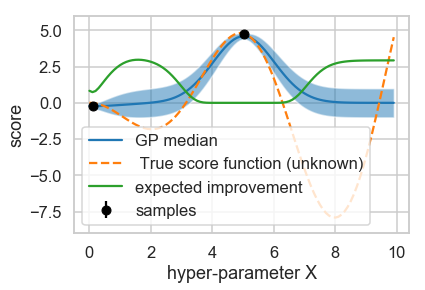

In [9]:
fig, ax = basic_plot()
# expected improvement would need its own y axis, so just multiply by ten
ax.plot(x, 10*np.abs(expected_improvement(x, gp, yp)), label='expected improvement')
ax.legend(loc='best')
print("The algorithm suggests sampling at X=%.4f" % (next_sample(gp, yp)))